<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
### <font color='blue'>Modelagem de Séries Temporais e Real-Time Analytics com Apache Spark e Databricks</font>
### <font color='blue'>Projeto 1 - Tarefa 2</font>
### <font color='blue'>Prevendo Usuários Ativos em Um Web Site</font>

## Instalando e Carregando os Pacotes

In [1]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
# !pip install -q -U watermark

In [2]:
# Imports para manipulação de dados
import pandas as pd

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Imports para análise e modelagem de séries temporais
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

In [3]:
# Formatação para os gráficos e tabelas
plt.style.use('ggplot')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# Formatando os labels dos gráficos
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'

In [5]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

matplotlib : 3.7.2
seaborn    : 0.12.2
statsmodels: 0.14.0
pandas     : 2.2.0



## Carregando o Conjunto de Dados

In [6]:
# Carrega os dados
dados = pd.read_csv('dataset.csv', header = None)

In [7]:
# Ajustando o nome de cada coluna
dados.columns = ['mes', 'usuarios_ativos']

Vamos converter a data do tipo object (string) para o tipo apropriado, datetime, pois assim podemos usar métodos e atributos específicos de datas.

In [8]:
# Convertendo a coluna data de object para datetime  
dados['mes'] = pd.to_datetime(dados['mes'], format = '%Y-%m')

In [9]:
# Vamos transformar a coluna de data no índice do conjunto de dados. 
# Isso vai facilitar nosso trabalho mais a frente.
dados_serie = dados.set_index('mes')

In [10]:
dados_serie.head()

,usuarios_ativos
mes,
2013-01-01,110
2013-02-01,121
2013-03-01,135
2013-04-01,127
2013-05-01,128


Agora sim podemos chamar esse conjunto de dados de série temporal. Vamos visualizar o índice:

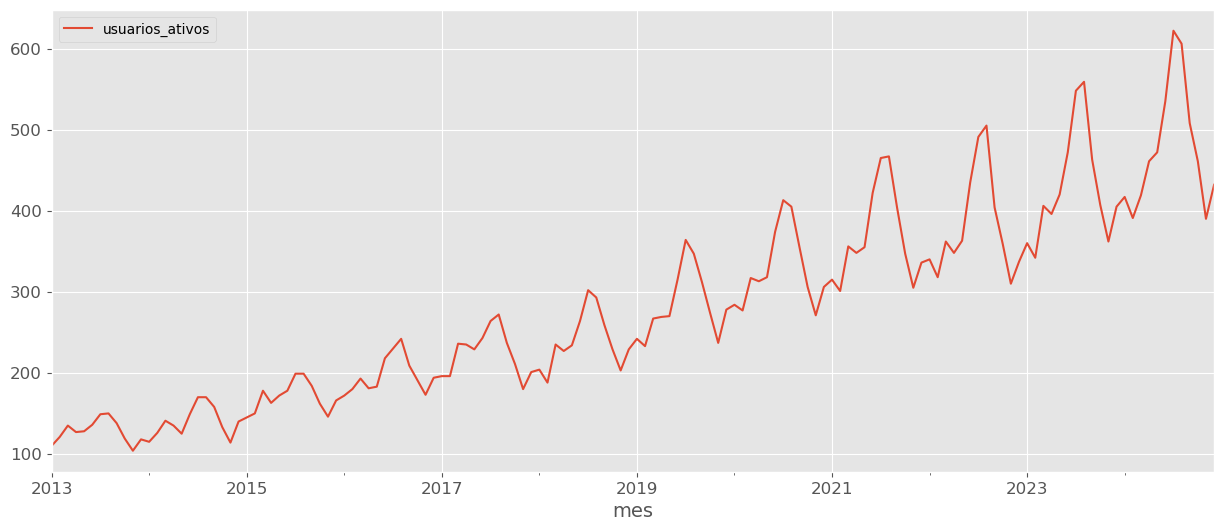

In [11]:
# Plot da série temporal
dados_serie.plot(figsize = (15, 6))
plt.show()

O gráfico acima mostra 2 componentes da série: Sazonalidade e Tendência.

- Sazonalidade - o fenômeno se repete em períodos fixos.

- Tendência - ao longo do tempo, a série segue uma tendência de crescimento.

## Propriedades Estatísticas de Séries Temporais

Antes de iniciar qualquer modelagem preditiva em séries temporais é necessário verificar se essas propriedades estatísticas são constantes na série temporal:

- **Estacionariedade**: a série temporal **deve** ser estacionária, ou seja, suas características estatísticas, como média e variância, não mudam ao longo do tempo.


- **Não-autocorrelação**: as observações da série temporal não devem ser fortemente correlacionadas com observações anteriores.


- **Normalidade**: é frequentemente pressuposto que as observações da série temporal são distribuídas normalmente (seguem uma distribuição normal).

### Plot das Rolling Statistics (Estatísticas Móveis)

As estatísticas móveis, também conhecidas como estatísticas rolantes ou estatísticas deslizantes, são uma técnica usada na análise de séries temporais para calcular estatísticas, como média, mediana, soma, variância e desvio padrão, em uma janela deslizante de tamanho fixo ao longo da série. A ideia é analisar e entender as mudanças nas estatísticas locais ao longo do tempo, o que pode ajudar a identificar tendências, sazonalidade, pontos de mudança e outras características dos dados.

Para calcular estatísticas móveis, você define uma janela de tamanho 'n' (onde n é um número inteiro) e move a janela ao longo da série temporal, calculando a estatística desejada para cada subconjunto de dados dentro da janela. A janela avança uma observação de cada vez e o cálculo é repetido até que a janela alcance o final da série.

Por exemplo, para calcular a média móvel de uma série temporal, você seleciona uma janela de tamanho n e calcula a média dos valores dentro da janela. Em seguida, a janela é deslocada uma posição à frente e a média é recalculada para os novos valores na janela. Esse processo é repetido até que a janela atinja o final da série temporal.

Primeiro, vamos checar se as estatísticas móveis são ou não constantes ao longo da série temporal.

In [12]:
type(dados)

pandas.core.frame.DataFrame

In [13]:
# Determinando estatísticas móveis
rolmean = dados['usuarios_ativos'].rolling(window = 12).mean()
rolstd = dados['usuarios_ativos'].rolling(window = 12).std()

In [14]:
# Prepara os dados para o plot
x = dados['mes'].values
y = dados['usuarios_ativos'].values

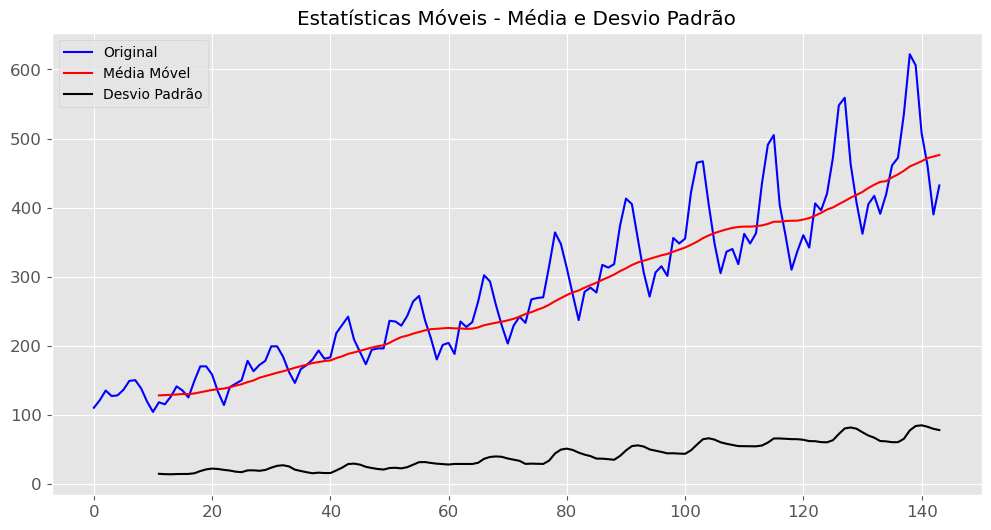

In [15]:
# Plot das estatísticas móveis
plt.figure(figsize = (12, 6))
orig = plt.plot(y, color = 'blue', label = 'Original')
mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
plt.legend(loc='best')
plt.title('Estatísticas Móveis - Média e Desvio Padrão')
plt.show()

Análise:
    
- Observamos que a média móvel e o desvio padrão não são constantes em relação ao tempo (tendência crescente).
- A série não é, portanto, estacionária.

### Plots da Função de Autocorrelação (ACF) e Função de Autocorrelação Parcial (PACF)

Vamos criar os gráficos da ACF e PACF.

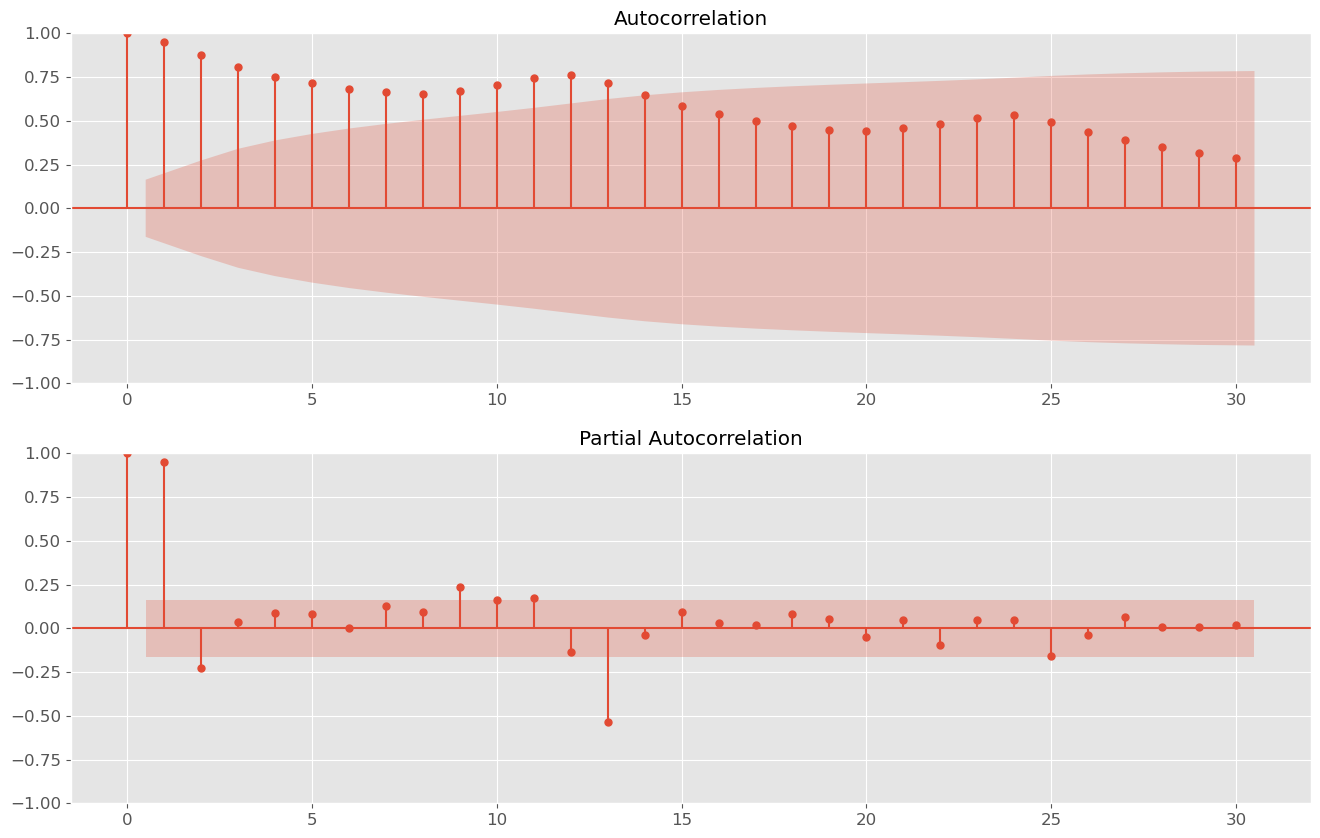

In [16]:
# Plots
plt.rcParams.update({'figure.figsize': (16,10)})

# Plot do gráfico ACF
plt.subplot(211)
plot_acf(dados_serie.usuarios_ativos, ax = plt.gca(), lags = 30)

# Plot do gráfico PACF
plt.subplot(212)
plot_pacf(dados_serie.usuarios_ativos, ax = plt.gca(), lags = 30, method = 'ywm')
plt.show()

Interpretação dos Gráficos:
    
No gráfico, o eixo vertical indica a autocorrelação e o horizontal a defasagem. 

A área sombreada indica onde é significativamente diferente de zero. Como é possível ver na imagem, temos diversos valores ACF (barras verticais) acima do limite da área sombreada. Nesses casos, a autocorrelação é diferente de zero, indicando que a série não é aleatória – conforme o esperado.

Algumas barras verticais estão dentro do limite da área sombreada. Ou seja, a autocorrelação entre a série com alguns de seus lags é igual a zero, indicando que não há correlação.

Em termos simples: a área sombreada aponta a significância. Se ultrapassada é porque tem correlação.

Cada barra no gráfico ACF representa o nível de correlação entre a série e seus atrasos em ordem cronológica. A área sombreada indica se o nível de correlação entre a série e cada atraso é significativo ou não. 

O PACF é apenas uma visualização parcial do ACF.

Análise:
    
- Se a série temporal for estacionária, os gráficos do ACF / PACF mostrarão uma "queda rápida na correlação" após um pequeno atraso entre os pontos. Não é o caso em nossos gráficos. A queda lenta (redução do tamanho das barras) indica que essa série não é estacionária.

- Os dados da nossa série não são estacionários, pois um número alto de observações anteriores está correlacionado com valores futuros.

- Intervalos de confiança são desenhados na área sombreada. Por padrão, isso é definido como um intervalo de confiança de 95%, sugerindo que os valores de correlação fora desta área provavelmente são uma correlação e não um acaso estatístico.

- Teremos que transformar essa série em estacionária antes de criar um modelo preditivo. Veremos isso mais adiante.

Aqui estão os principais aspectos que você busca ao interpretar um gráfico ACF:

**1. Dependência Temporal**

ACF mede a correlação entre observações de uma série temporal separadas por diferentes lags (defasagens). Um pico significativo em um lag específico indica que os valores na série temporal estão correlacionados com seus valores em lags anteriores. Isso é fundamental para identificar se a série possui dependência temporal.

**2. Identificação de Sazonalidade**

Se o gráfico ACF mostra picos regulares em intervalos específicos, isso pode indicar a presença de sazonalidade na série. Por exemplo, um pico significativo a cada 12 lags em dados mensais pode sugerir um padrão sazonal anual.

**3. Determinação da Ordem de Modelos ARIMA**

Para modelos ARIMA (AutoRegressive Integrated Moving Average), a análise do gráfico ACF (junto com o PACF - Função de Autocorrelação Parcial) pode ajudar a determinar a ordem dos componentes AR (autoregressivos) e MA (médias móveis). Por exemplo, um declínio gradual no ACF sugere componentes AR, enquanto um corte brusco após um lag específico sugere componentes MA.

**4. Estacionariedade**

Uma série temporal é estacionária se sua média e variância permanecem constantes ao longo do tempo. No gráfico ACF, uma diminuição muito lenta ou a ausência de diminuição nas autocorrelações pode indicar que a série não é estacionária. A estacionariedade é muitas vezes um pré-requisito para a modelagem eficaz de séries temporais.

**5. Ruído Branco**

Se todas as autocorrelações são insignificantes (ou seja, próximas de zero para todos os lags), a série pode ser um ruído branco, indicando que os valores são independentes e identicamente distribuídos. Isso significa que a série não possui padrões previsíveis ou dependência temporal significativa.

In [17]:
dados_serie

,usuarios_ativos
mes,
2013-01-01,110
2013-02-01,121
2013-03-01,135
2013-04-01,127
2013-05-01,128
...,...
2024-08-01,606
2024-09-01,508
2024-10-01,461


### Teste Estatístico Dickey-Fuller Aumentado

O Teste Estatístico Dickey-Fuller Aumentado (ADF, do inglês Augmented Dickey-Fuller) é uma versão ampliada do teste de Dickey-Fuller, usado para verificar a presença de raiz unitária em uma série temporal, ou seja, para testar a estacionariedade da série. Uma série temporal é considerada estacionária quando suas propriedades estatísticas, como média e variância, são constantes ao longo do tempo. A presença de uma raiz unitária indica que a série é não estacionária, o que pode afetar a análise e a modelagem dessa série.

O teste ADF é particularmente útil porque pode acomodar uma estrutura de autocorrelação mais complexa em comparação com o teste Dickey-Fuller original. Isso é feito incluindo termos de defasagem da variável dependente (lags) na equação de teste para controlar a autocorrelação serial.

Estas são as hipóteses do teste:

- Hipótese Nula (H0): A série possui uma raiz unitária (γ=0), indicando não estacionariedade.
- Hipótese Alternativa (H1): A série não possui raiz unitária (γ<0 para o caso unicaudal), indicando estacionariedade.

Ou, de forma mais simples:

- Hipótese Nula (H0): A série temporal não é estacionária.
- Hipótese Alternativa (H1) - A série temporal é estacionária.

In [18]:
# Teste Dickey-Fuller

# Print
print('\nResultado do Teste Dickey-Fuller:\n')

# Teste
dfteste = adfuller(dados_serie.usuarios_ativos, autolag = 'AIC')

# Formatando a saída
dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                           'Valor-p',
                                           'Número de Lags Consideradas',
                                           'Número de Observações Usadas'])

# Loop por cada item da saída do teste
for key,value in dfteste[4].items():
    dfsaida['Valor Crítico (%s)'%key] = value

# Print
print (dfsaida)


Resultado do Teste Dickey-Fuller:

Estatística do Teste              0.809204
Valor-p                           0.991783
Número de Lags Consideradas      13.000000
Número de Observações Usadas    130.000000
Valor Crítico (1%)               -3.481682
Valor Crítico (5%)               -2.884042
Valor Crítico (10%)              -2.578770
dtype: float64


Análise:

- O Valor-p é maior que 0.05. Não temos evidências estatísticas para rejeitar a hipótese nula de que a série não é estacionária. Logo, podemos concluir que a série NÃO é estacionária.

## Automatizando  o Teste de Estacionariedade

E aqui um presente para você. Uma função que executa o teste de estacionaridade e pode ser aplicada a qualquer série para testar se ela é ou não estacionária.

**Se a série não for estacionária, teremos que aplicar transformações antes da modelagem. Em nosso exemplo, a série não é estacionária e vamos transformá-la em estacionária mais adiante.**

Isso vale para qualquer série temporal.

In [19]:
# Função para testar a estacionaridade
def dsa_testa_estacionaridade(serie, window = 12, title = 'Estatísticas Móveis e Teste Dickey-Fuller'):
    """
    Função para testar a estacionaridade de uma série temporal.
    
    Parâmetros:
    - serie: pandas.Series. Série temporal a ser testada.
    - window: int. Janela para cálculo das estatísticas móveis.
    - title: str. Título para os gráficos.
    """
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = window).mean()
    rolstd = serie.rolling(window = window).std()

    # Plot das estatísticas móveis
    plt.figure(figsize = (14, 6))
    plt.plot(serie, color = 'blue', label = 'Original')
    plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    plt.plot(rolstd, color = 'black', label = 'Desvio Padrão Móvel')
    plt.legend(loc = 'best')
    plt.title(title)
    plt.show(block = False)
    
    # Teste Dickey-Fuller
    print('\nResultado do Teste Dickey-Fuller:')
    dfteste = adfuller(serie, autolag = 'AIC')
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste', 
                                               'Valor-p', 
                                               'Número de Lags Consideradas', 
                                               'Número de Observações Usadas'])
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)' % key] = value
        
    print(dfsaida)
    
    # Conclusão baseada no valor-p
    if dfsaida['Valor-p'] > 0.05:
        print('\nConclusão:\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.\nEssa série provavelmente não é estacionária.')
    else:
        print('\nConclusão:\nO valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.\nEssa série provavelmente é estacionária.')

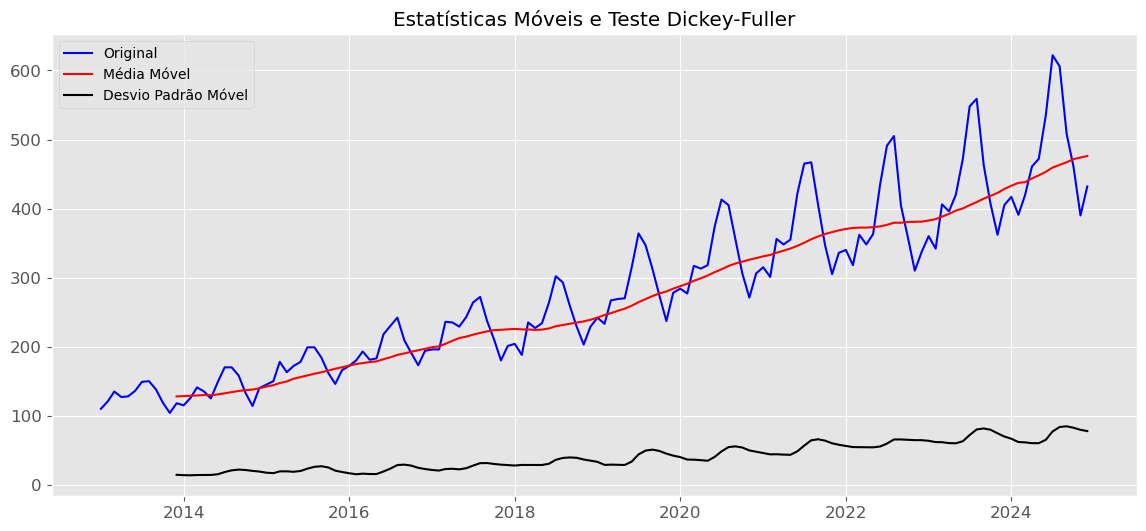


Resultado do Teste Dickey-Fuller:
Estatística do Teste              0.809204
Valor-p                           0.991783
Número de Lags Consideradas      13.000000
Número de Observações Usadas    130.000000
Valor Crítico (1%)               -3.481682
Valor Crítico (5%)               -2.884042
Valor Crítico (10%)              -2.578770
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [20]:
# Executando nossa função
dsa_testa_estacionaridade(dados_serie)

Vamos para a Tarefa 3 na próxima aula.

In [21]:
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



In [22]:
#%watermark -v -m

In [23]:
#%watermark --iversions

# Fim da Tarefa 2